# Demo
Integrating sub-cellular spots into single-cell level spots based on an improved version of TopACT (i.e., pytacs here).

In [1]:
import pytacs
import scanpy as sc

In [2]:
# Step 1. Prepare the snRNA-seq and spRNA-seq data
sp_adata = sc.read_h5ad('h5ad/spRNA_mouse_demo.h5ad')
sp_adata.obsm['spatial'] = sp_adata.obs[['x','y']].values

data_preper = pytacs.AnnDataPreparer(
    sn_adata=sc.read_h5ad('h5ad/snRNA_mouse_demo.h5ad'),
    sp_adata=sp_adata,
)
print(data_preper)

--- AnnDataPreparer (pytacs) ---
- sn_adata: AnnData object with n_obs × n_vars = 2000 × 769
    obs: 'cell_type', 'old_index'
- sp_adata: AnnData object with n_obs × n_vars = 6556 × 5227
    obs: 'x', 'y', 'old_index'
    obsm: 'spatial'
- downsampled_adata: _UNDEFINED
--- --- --- --- ---



In [3]:
# Step 2. Train a local classifier
clf = pytacs.SVM(threshold_confidence=0.5, log1p=True, normalize=True, on_PCs=False)
clf.fit(
    sn_adata=data_preper.sn_adata
)

In [4]:
# Step 3. Integrate spatial spots into single-cell spots
result = pytacs.rw_aggregate(
    st_anndata=data_preper.sp_adata,
    classifier=clf,
)

Performing truncated PCA (n_pcs=30)..
Constructing spatial graph..
Classifying..


Gather iter 1 results: 100%|█| 6556/6556 [00:00<00:00, 38319

Ave conf: 72.12%
counter_celltypes={'Other': 5473, 'PT': 1083}
counter_celltypes_global={'Other': 5473, 'PT': 1083}


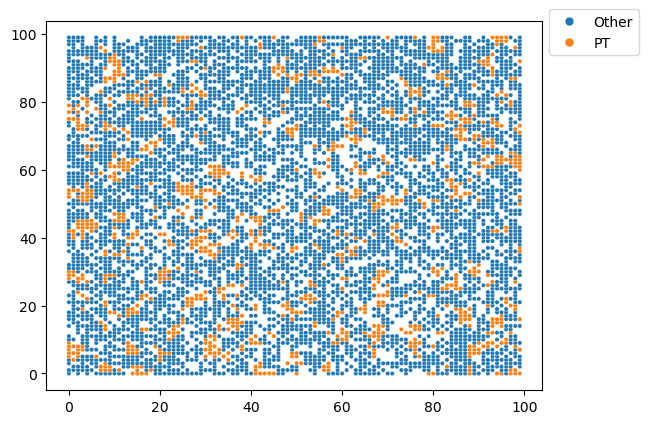

In [5]:
# See type predictions
celltypes = pytacs.extract_celltypes_full(result)
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(
    x=data_preper.sp_adata.obsm['spatial'][:,0],
    y=data_preper.sp_adata.obsm['spatial'][:,1],
    hue=celltypes,
    s=10,
)
plt.legend(bbox_to_anchor=(1,1.05), loc='upper left', markerscale=2,)
plt.show()

In [6]:
# Step 4. Get integrated single-cell level ST data
sp_sc = pytacs.celltype_refined_bin(
    ann_count_matrix=pytacs.SpatialTypeAnnCntMtx(
        count_matrix=data_preper.sp_adata.X,
        spatial_coords=data_preper.sp_adata.obsm['spatial'],
        cell_types=celltypes,
    ),
    fraction_subsampling=0.7,
)

Subsampling 70.000000% i.e. 4589 samples..
Building spatial distance matrix..


Building CTRBin: 100%|███████| 2/2 [00:00<00:00, 308.03it/s]


In [7]:
adata_spsc = sc.AnnData(
    X=sp_sc.count_matrix,
    obs={'cell_type': sp_sc.cell_types},
    obsm={'spatial': sp_sc.spatial_coords},
)
adata_spsc.var.index = sp_adata.var.index
adata_spsc

AnnData object with n_obs × n_vars = 4589 × 5227
    obs: 'cell_type'
    obsm: 'spatial'

In [8]:
# Perform cell niche identification
niches = pytacs.cluster_spatial_domain(
    coords=data_preper.sp_adata.obsm['spatial'],
    cell_types=celltypes,
    n_clusters=2,
)

Compute celltype proportions: 100%|█| 6556/6556 [00:01<00:00


Agglomerative clustering ...
Done.


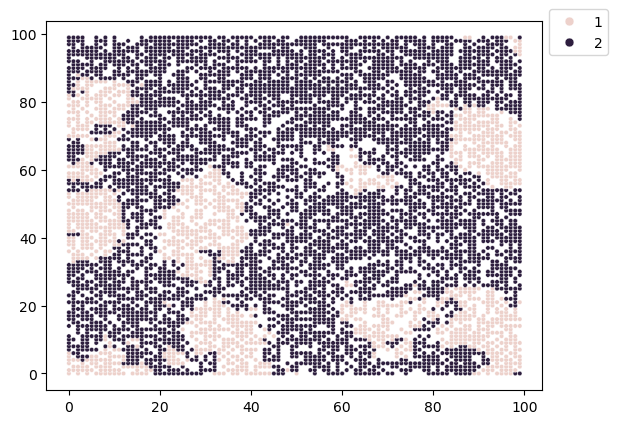

In [ ]:
sns.scatterplot(
    x=data_preper.sp_adata.obsm['spatial'][:,0],
    y=data_preper.sp_adata.obsm['spatial'][:,1],
    hue=niches,
    s=10,
)
plt.legend(bbox_to_anchor=(1,1.05), loc='upper left', markerscale=2,)
plt.show()